# Tutorial PXCT data analysis (PART 1) - HERCULES school 2021

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) 
### email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

### <span style="color:red">** Disclaimer: This notebook is intended from educational reasons only.**</span>

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://mybinder.org/v2/gh/jcesardasilva/tutorialHercules.git/HEAD"><img src="https://mybinder.org/static/images/logo_social.png" height="52" width="62"/>Run in MyBinder.org</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/jcesardasilva/tutorialHercules/blob/master/PXCT/PXCT_pipeline_part1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://jupyter-slurm.esrf.fr/"><img src="https://upload.wikimedia.org/wikipedia/fr/thumb/3/37/ESRF_-_Grenoble.png/280px-ESRF_-_Grenoble.png" height="40" width="40"/>Run in Jupyter-Slurm at ESRF (needs login)</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer" href="https://github.com/jcesardasilva/tutorialHercules.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
   </td>
    
</table>

**All the steps of this processing pipeline are described in:**

*da Silva, J. C., Haubrich, J., Requena, G., Hubert, M., Pacureanu, A., Bloch, L., Yang, Y., Cloetens, P., “High energy near-and far-field ptychographic tomography at the ESRF”. Proc. SPIE 10391, Developments in X-Ray Tomography XI, 1039106 (2017). [doi: 10.1117/12.2272971](https://doi.org/10.1117/12.2272971)*

**REMARKS: the references of this paper contains a list of important and more pioneering works on the PXCT data processing steps**

### Toupy - Tomographic Utilities for Python

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://toupy.readthedocs.io"><img src="https://toupy.readthedocs.io/en/latest/_static/toupy_logo.png" width="20%"/></a>
  </td>
</table>

**For the PXCT data analysis, we will use the python suite [*Toupy*](https://toupy.readthedocs.io/), which is maintained by me, but open to contributions from the community.**

<span style="color:blue">**Another suite of routines for PXCT data processing is [*PtychoShelves*](https://journals.iucr.org/j/issues/2020/02/00/zy5001/), which is high optimized and provided even very advanced algorithms. It run in MATLAB and it is compatible with GPUs**</span>

This tutorial needs a package called Toupy, which can be installed as (if not already installed):

    pip install --user git+https://github.com/jcesardasilva/toupy.git@hercules

In [1]:
#!pip install --user git+https://github.com/jcesardasilva/toupy.git@hercules # uncomment this line if not installed

Importing the dependencies:

In [2]:
#%matplotlib ipympl
# standard packages
import os
import tarfile
import warnings
warnings.filterwarnings('ignore') # getting rid of annoying warnings.
# third party packages
#import ipympl
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import toupy
from toupy.utils import downloadURLfile # Toupy provides a routine to download the data from the URL

#### Loading the data
We now load the data. We will use a dataset we obtained at cSAXS beamline (PSI, CH) by applying PXCT on the characterizationn of a shaped Fluid Catalytic Cracking (FCC) catalyst. The open-access publication from 2015 can be found [here](https://doi.org/10.1002/cctc.201402925)*. FCC catalysts are important shaped catalysts for the oil industry which enable the conversion of crude oil (petroleum) into more valuable products (E.g. gasoline, olefinic gases).

***da Silva, J. C., Mader, K., Holler, M., Haberthür, D., Diaz, A., Guizar-Sicairos, M., Cheng, W-.C., Shu, Y., Raabe, J., Menzel, A., van Bokhoven, J. A., “Assessment of the 3D pore structure and individual components of preshaped catalyst bodies by X-ray imaging”, ChemCatChem 7, 413-416 (2015)**

The file containing the data should be `PXCTprojections.npz`, which contains the complex-values PXCT projections. Let us download the file from internet first:

In [3]:
#-----------
download_file = True
usingBinder = False
#-----------
tarfname = "PXCTprojections.tar.gz"
if download_file:
    if not usingBinder:
        urldata = 'https://cloud.neel.cnrs.fr/index.php/s/miwbixj5kzGQKEd/download'
    else: 
        ### For those using mybinder, please uncomment the line below:
        urldata = 'https://cloud.neel.cnrs.fr/index.php/s/y56yKtDKPwDb9GQ/download'
    downloadURLfile(urldata, tarfname) # this may take time depending on internet speed
# uncompress and extract the file
print("Uncompressing and extracting the file")
tf = tarfile.open(tarfname)
tf.extractall()
print("Removing the file we will not use anymore")
os.remove(tarfname)

Downloading: https://cloud.neel.cnrs.fr/index.php/s/miwbixj5kzGQKEd/download Bytes: 1230014781
      1230014781   [100.00%]
Uncompressing and extracting the file
Removing the file we will not use anymore


<span style="color:red"> **Remark:**
For the sake of speed and to reduce the computing resources required for this tutorial, the projections have been downsized (binned) by a factor 2, which also means the pixel size is twice larger than the original pixel size. Nevertheless, this does not affect the data processing step, which should be identical for the original dataset. </span>

We can now load the data from the file:

In [4]:
if not usingBinder:
    fname = "PXCTprojections.npz"
else:
    print("Using mybinder")
    fname = "PXCTonlyphases.npz"
data_dict = np.load(fname) # load the file
list(data_dict.files) # this one list the keys of the data dictionary extracted from the file

['wavelen', 'psize', 'projections', 'theta']

You can, for example, get the wavelength of the pixel size:

In [5]:
wavelen = data_dict['wavelen']
pixsize = data_dict['psize']

print(f"The projection pixel size of the projections is {pixsize/1e-9:.02f} nm")
print(f"The wavelenth of the incoming photons is {wavelen/1e-10:.02f} Angstroms")

The projection pixel size of the projections is 28.64 nm
The wavelenth of the incoming photons is 2.00 Angstroms


We should also get the tomographic angles (`theta`) and the complex-valued projections, from which we should extract only the phases:

In [6]:
theta = data_dict['theta']
if not usingBinder:
    projections = data_dict['projections'] # <- ATTENTION: this one is memory consuming. 
    projections = np.angle(projections).astype(np.float32) # Get the phases of the complex-valued projections
else:
    print("Using mybinder")
    projections = data_dict['projections'].astype(np.float32) 
nproj, nr, nc = projections.shape

The angular sampling interval is 0.40 degrees
The angular sampling interval within each subtomo is 3.20 degrees


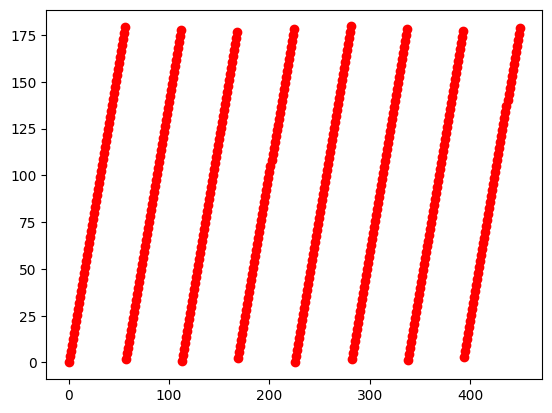

In [7]:
delta_theta = np.diff(np.sort(theta))[0]
delta_theta_subtomo = np.diff(theta)[0]
print(f"The angular sampling interval is {delta_theta:.02f} degrees")
print(f"The angular sampling interval within each subtomo is {delta_theta_subtomo:.02f} degrees")
plt.plot(theta,'ro')

Let us take a look at one projection. I will select the first and last ones,i.e. at angles 0 and 180-$\Delta\theta$ degress:

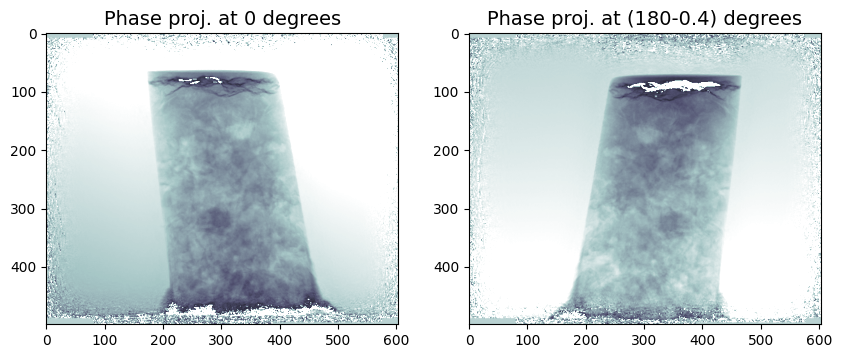

In [8]:
plt.close('all')
fig1 = plt.figure(1,figsize=(10,4))
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(projections[0],cmap='bone', vmin=-4, vmax=1)
ax1.set_title('Phase proj. at 0 degrees',fontsize = 14)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig1.colorbar(im1,cax=cax)
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(projections[-1],cmap='bone', vmin=-4, vmax=1)
ax2.set_title('Phase proj. at (180-0.4) degrees',fontsize = 14)
#display.display(plt.gcf())
display.clear_output(wait=True)

#### Removing linear phase ramp
You may have notice the linear phase ramp in the image. The first step of the PXCT data analysis is correcting for that ramp as we do below. 

**Toupy** provides an iterative enviroment to select the mask area, but interactive plot from matplotlib are not supported in Jupyter notebooks, unfortunately. Otherwise, one could use the commented lines below:

Done. When finished, close figure and press <Enter> to exit


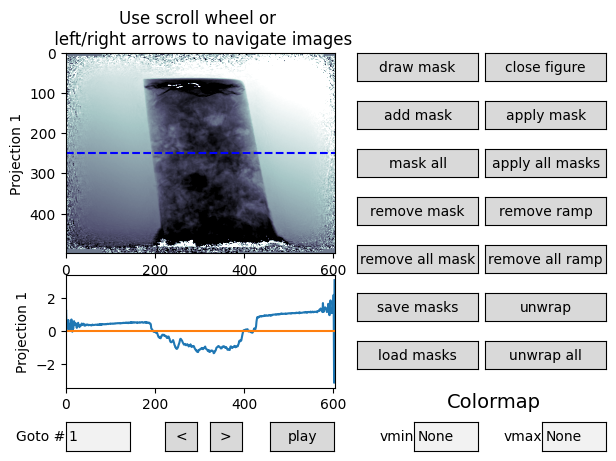

Press Enter to finish
 


In [9]:
from toupy.restoration import gui_plotphase
stack_phasecorr = gui_plotphase(projections,vmin=-1.6,vmax=1.6, crop_reg = None, colormap='bone') #<-- iterative plots like this are not allowed in jupyter, 
                                                      #  but can be used out of the jupyter enviroment

So, instead of the interactive plot, let us do it manually. Let us first plot one projection to look at the ramp and air area:

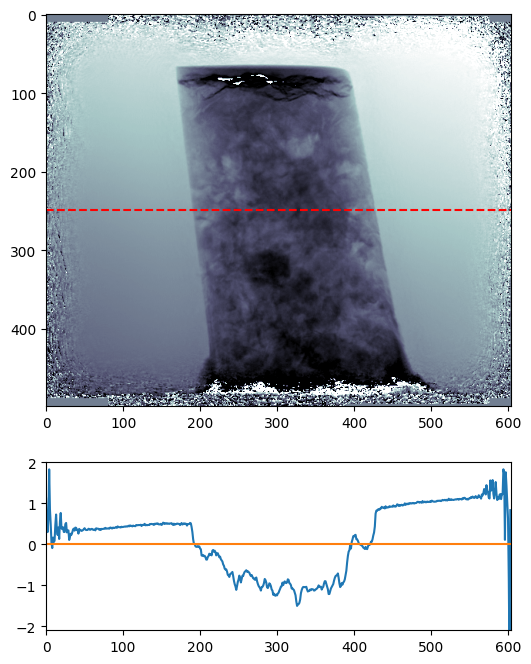

In [10]:
import matplotlib.gridspec as gridspec
#-----------
# parameters
#------------
projnum = 1 # projection number
pvmin = -2.1 # gray scale minimum value
pvmax = 2 # gray scale maximum value
#------------
# Displaying the images
fig2 = plt.figure(2,figsize=(6,8))
gs = gridspec.GridSpec(
        2, 1, width_ratios=[4], height_ratios=[7,3]  # figure=4,
    )
ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(projections[projnum],cmap="bone",vmin=pvmin,vmax=pvmax)
ax1.axis('tight')
ax1.plot([0,nc],[int(nr/2),int(nr/2)],'r--')
ax2 = plt.subplot(gs[1])
im2 = ax2.plot(projections[projnum,int(nr/2),:])
ax2.plot([0,nc],[0,0])
ax2.set_xlim([0,nc])
ax2.set_ylim([pvmin,pvmax])
#display.display(plt.gcf())
display.clear_output(wait=True)

#### Creating the mask
We should create a mask containing only area with air/vacuum around the sample:

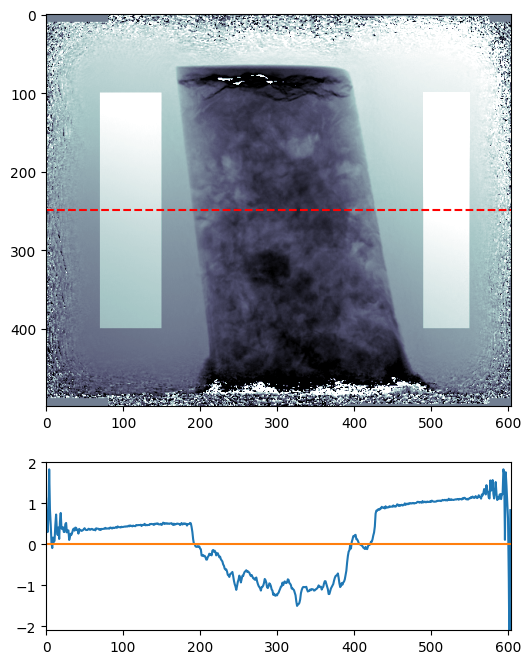

In [11]:
maskair = np.zeros_like(projections[0])
maskair[100:400,70:150]=1
maskair[100:400,490:550]=1
#-----------
# parameters
#------------
projnum = 1 # projection number
pvmin = -2.1 # gray scale minimum value
pvmax = 2 # gray scale maximum value
#------------

# Displaying the images
fig2 = plt.figure(2,figsize=(6,8))
gs = gridspec.GridSpec(
        2, 1, width_ratios=[4], height_ratios=[7,3]  # figure=4,
    )
ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(projections[projnum]+maskair,cmap="bone",vmin=pvmin,vmax=pvmax)
ax1.axis('tight')
ax1.plot([0,nc],[int(nr/2),int(nr/2)],'r--')
ax2 = plt.subplot(gs[1])
im2 = ax2.plot(projections[projnum,int(nr/2),:])
ax2.plot([0,nc],[0,0])
ax2.set_xlim([0,nc])
ax2.set_ylim([pvmin,pvmax])
#display.display(fig2)
#display.display(fig2.canvas)
display.clear_output(wait=True)

#### Applying the mask
Let us apply the mask to one projection

In [12]:
from toupy.restoration import rmlinearphase
from toupy.utils import progbar

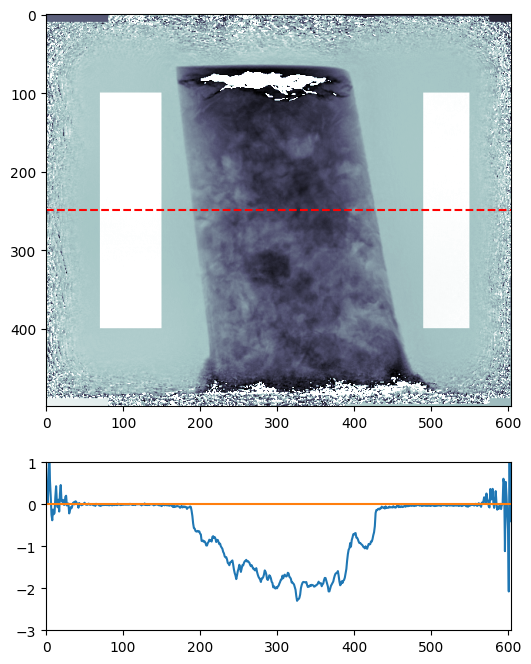

In [13]:
#-----------
# parameters
#------------
projnum = 1 # projection number
pvmin = -3 # gray scale minimum value
pvmax = 1 # gray scale maximum value
#------------
imgin = np.exp(1j * projections[projnum]).copy() # Deep copy
projcorr = np.angle(rmlinearphase(imgin, maskair)).copy()
# Displaying the images again
fig2 = plt.figure(2,figsize=(6,8))
gs = gridspec.GridSpec(
        2, 1, width_ratios=[4], height_ratios=[7,3]  # figure=4,
    )
ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(projcorr+maskair,cmap="bone",vmin=pvmin,vmax=pvmax)
ax1.axis('tight')
ax1.plot([0,nc],[int(nr/2),int(nr/2)],'r--')
ax2 = plt.subplot(gs[1])
im2 = ax2.plot(projcorr[int(nr/2),:])
ax2.plot([0,nc],[0,0])
ax2.set_xlim([0,nc])
ax2.set_ylim([pvmin,pvmax])
#display.display(plt.gcf())
display.clear_output(wait=True)

Great! It works. So, we can proceed with all the other projections:

In [14]:
projcorr = np.empty_like(projections)
for ii in range(nproj):
    strbar = "Projection {} out of {}".format(ii + 1, nproj)
    imgin = np.exp(1j * projections[ii]).copy() # Deep copy
    projcorr[ii] = np.angle(rmlinearphase(imgin, maskair)).copy()
    progbar(ii+1,nproj,strbar)
# release some memory
del imgin
del maskair
del projections

 ######################################## [100.00%] Projection 450 out of 450

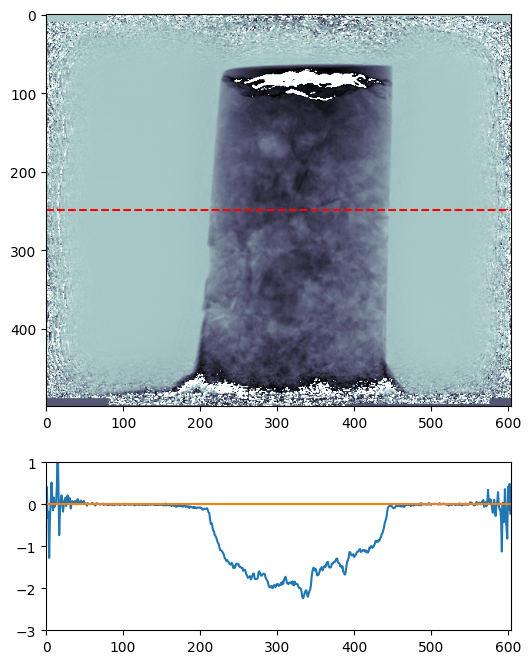

In [15]:
# Do you want to check the results? Take a look:
#-----------
# parameters
#------------
projnum = 50 # projection number
pvmin = -3 # gray scale minimum value
pvmax = 1 # gray scale maximum value
#------------

# Displaying the images
fig2 = plt.figure(2,figsize=(6,8))
gs = gridspec.GridSpec(
        2, 1, width_ratios=[4], height_ratios=[7,3]  # figure=4,
    )
ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(projcorr[projnum],cmap="bone",vmin=pvmin,vmax=pvmax)
ax1.axis('tight')
ax1.plot([0,nc],[int(nr/2),int(nr/2)],'r--')
ax2 = plt.subplot(gs[1])
im2 = ax2.plot(projcorr[projnum,int(nr/2),:])
ax2.plot([0,nc],[0,0])
ax2.set_xlim([0,nc])
ax2.set_ylim([pvmin,pvmax])
display.clear_output(wait=True)

#### Phase unwrapping
Although there are very few area where the phases are wrapped, it will be benefitial to unwrap them.

In [16]:
# import the toupy routines we will need
from toupy.restoration import phaseresidues, chooseregiontounwrap, unwrapping_phase
from toupy.utils import iterative_show

Checking for phase residues
 ######################################## [100.00%]   3358 res./proj.    450. Done


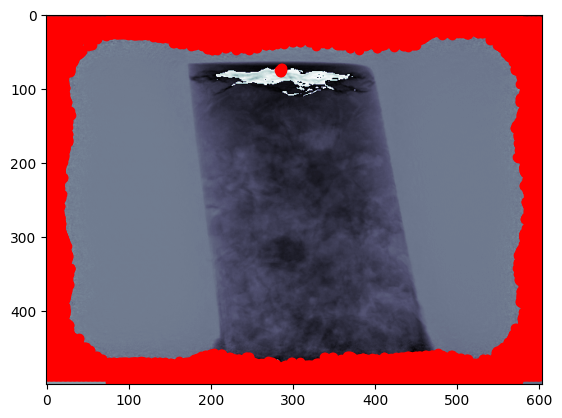

The array dimensions are 499 x 604
Please, choose an area for the unwrapping:


From edge of region to edge of image in x:  55
Range in y (top, bottom):  55,450
Pixel in air (x,y) or (col,row):  100,100


Chosen region contains 7 residues in total


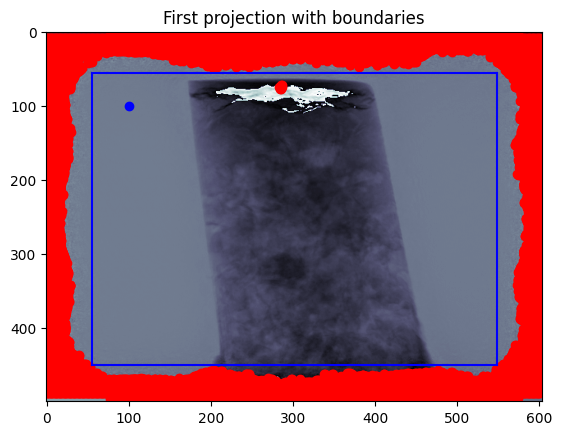

Are you happy with the boundaries?([y]/n) y


In [17]:
# find the residues and choose region to be unwrapped
rx, ry, airpix = chooseregiontounwrap(projcorr)

Do you want to edit the color scale?([y]/n) n


Color scale was not changed. Using vmin=-3 and vmax=1
Parallel calculations using 2 cpus


100%|█████████████████████████████████████████| 450/450 [00:09<00:00, 46.43it/s]


Correcting for air values


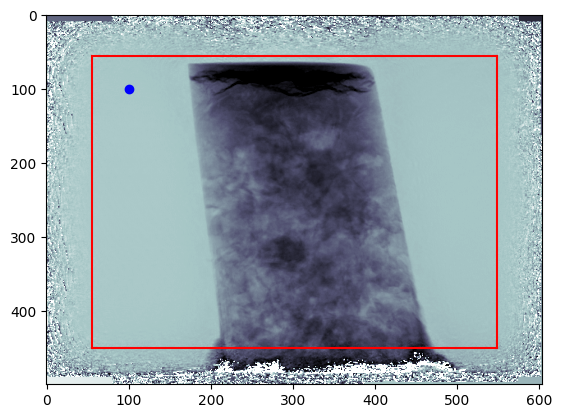

In [18]:
projunwrap = unwrapping_phase(projcorr, rx, ry, airpix, vmin=pvmin, vmax=pvmax, n_cpus=2)

In [19]:
del projcorr # release some memory

#### Let us save our progress so far and make a break for discution/questions

In [20]:
outputfname = "PXCTcorrprojections.npz"
np.savez(outputfname, wavelen = wavelen, psize = pixsize, projections = projunwrap, theta = theta)

In [21]:
!ls -lrth

total 7055248
-rw-r--r--  1 julio  staff   2.0G Feb 18  2021 PXCTprojections.npz
-rw-r--r--  1 julio  staff    19K May  9 10:21 PXCT_pipeline_part1.ipynb
-rw-r--r--  1 julio  staff   333M May  9 10:44 PXCTalignedprojections.npz
-rw-------  1 julio  staff   147M May  9 10:44 PXCT_pipeline_part2.ipynb
-rw-r--r--  1 julio  staff   365M May  9 10:49 PXCTtomogram.npz
-rw-------  1 julio  staff   1.3M May  9 10:49 PXCT_pipeline_part3.ipynb
-rw-r--r--  1 julio  staff    24K May  9 10:53 FSC_3D.png
-rw-------  1 julio  staff   624K May  9 10:53 PXCT_pipeline_extra.ipynb
-rw-------@ 1 julio  staff   517M May  9 10:55 PXCTcorrprojections.npz


In [22]:
## if you need to free some space, uncomment the line below
#os.system('/bin/rm PXCTprojections.npz')